In [1]:
from pathlib import Path
import math

In [2]:
import pandas as pd
import numpy as np
from scipy import stats

In [3]:
import cufflinks as cf
cf.set_config_file(offline=True, theme='solar')
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
pio.templates.default = pio.templates["plotly_dark"]

In [4]:
path = Path("CQF_June_2023_M1L1_SPX.csv")
assert path.exists()

In [5]:
raw_data = pd.read_csv(
    path,
    parse_dates=["Date"],
    dayfirst=True,
    index_col="Date",
)
raw_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0
1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,0
1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,0
1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,0
1928-01-09,17.500000,17.500000,17.500000,17.500000,17.500000,0


In [6]:
data = raw_data[["Adj Close"]]

In [7]:
def compute_returns(data: pd.DataFrame, dt=1) -> pd.DataFrame:
    # can be replaced with data.pct_change(dt)
    return (
        data
        .assign(Return=data["Adj Close"].diff(dt) / data["Adj Close"].shift(1))
        .dropna()
    )

data.pipe(compute_returns, dt=1)

,Adj Close,Return
Date,,
1928-01-04,17.719999,-0.002252
1928-01-05,17.549999,-0.009594
1928-01-06,17.660000,0.006268
1928-01-09,17.500000,-0.009060
1928-01-10,17.370001,-0.007429
...,...,...
2023-06-02,4282.370117,0.014534
2023-06-05,4273.790039,-0.002004
2023-06-06,4283.850098,0.002354


In [8]:
def compute_log_returns(data: pd.DataFrame, dt=1) -> pd.DataFrame:
    return (
        data
        .assign(Return=np.log(data["Adj Close"]).diff(dt))
        .dropna()
    )

data.pipe(compute_log_returns, dt=1)

,Adj Close,Return
Date,,
1928-01-04,17.719999,-0.002255
1928-01-05,17.549999,-0.009640
1928-01-06,17.660000,0.006248
1928-01-09,17.500000,-0.009101
1928-01-10,17.370001,-0.007456
...,...,...
2023-06-02,4282.370117,0.014430
2023-06-05,4273.790039,-0.002006
2023-06-06,4283.850098,0.002351


# Task 1

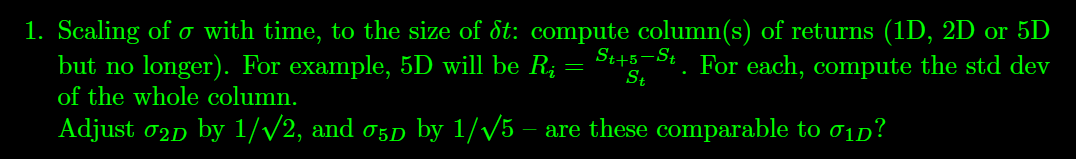

In [9]:
(
    pd.DataFrame(
        {
            i: data.pipe(compute_returns, dt=i).drop("Adj Close", axis=1).std()
            for i in [1, 2, 5]
        }
    ).T.assign(
        Adjusted=lambda df: df.apply(
            lambda row: row["Return"] / math.sqrt(row.name), axis=1
        )
    )
)

,Return,Adjusted
1,0.011989,0.011989
2,0.016859,0.011921
5,0.026454,0.011831


Yes, after normalizing the ${\sigma}$ with $1/\sqrt{t}$ they have much more comparable values.

# Task 2

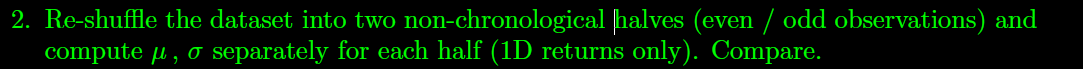

In [10]:
(
    data.pipe(compute_returns)
    .pipe(
        lambda df: pd.DataFrame(
            {
                "even": df.iloc[::2].describe()["Return"],
                "odd": df.iloc[1::2].describe()["Return"],
            }
        )
    )
    .assign(
        diff=lambda df: df["even"] - df["odd"],
        diff_pct=lambda df: df["diff"] / df["even"],
    )
)

,even,odd,diff,diff_pct
count,11986.000000,11986.000000,0.000000,0.000000
mean,0.000276,0.000326,-0.000049,-0.178183
std,0.011683,0.012288,-0.000606,-0.051854
min,-0.129403,-0.204669,0.075267,-0.581645
25%,-0.004635,-0.004481,-0.000154,0.033266
50%,0.000380,0.000582,-0.000202,-0.533305
75%,0.005404,0.005505,-0.000101,-0.018673
max,0.125306,0.166096,-0.040790,-0.325523


There is quite a big diffrence in ${\mu}$ while ${\sigma}$ stays about the same. 

# Task 3

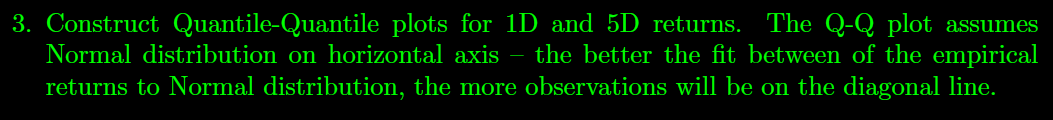

In [11]:
def z_stand(data: pd.DataFrame) -> pd.DataFrame:
    return (data - data.mean()) / data.std()

In [12]:
quantiles = np.linspace(0,1,100)

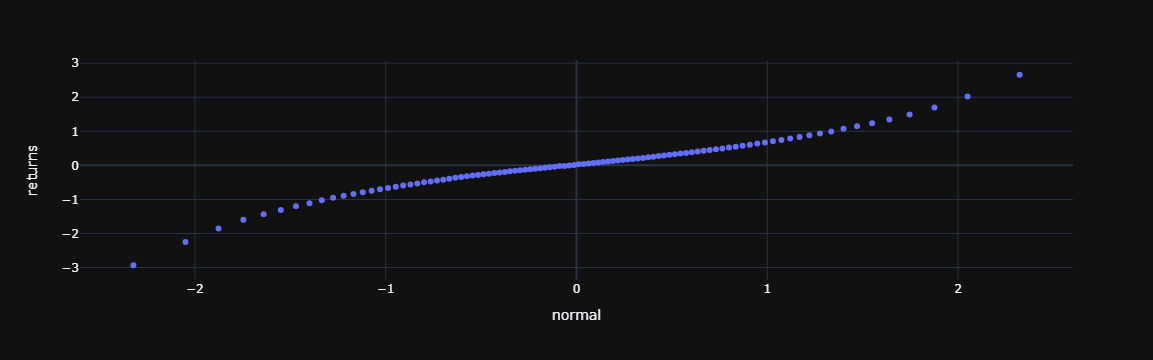

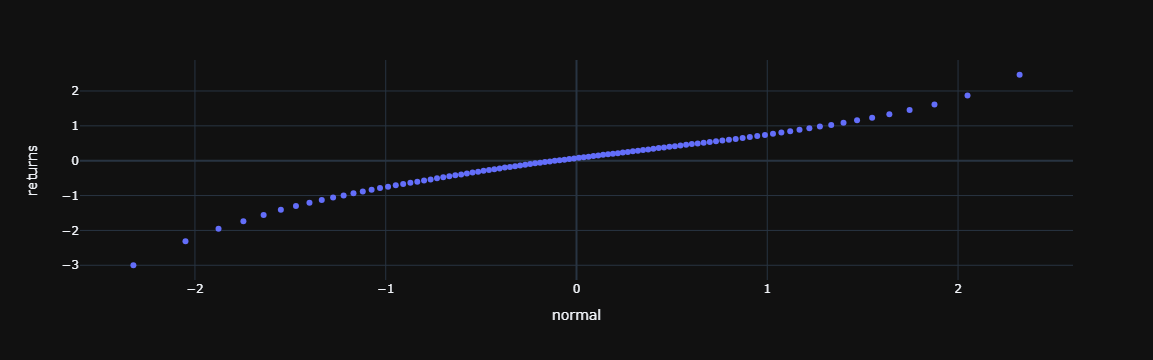

In [13]:
def qq(data: pd.DataFrame) -> pd.DataFrame:
    data_r = data["Return"].pipe(z_stand)
    q_returns = data_r.quantile(quantiles)
    q_normal = stats.norm.ppf(quantiles)
    return (
        pd.DataFrame({"normal": q_normal, "returns": q_returns, "quantiles": quantiles})
        .set_index("quantiles")
    )

def show_qq(data: pd.DataFrame):
    (
        qq(data)
        .iloc[1:-1]
        .pipe(px.scatter, x="normal", y="returns")
        .show()
    )

show_qq(data.pipe(compute_log_returns, dt=1))
show_qq(data.pipe(compute_returns, dt=5))

# Task 4

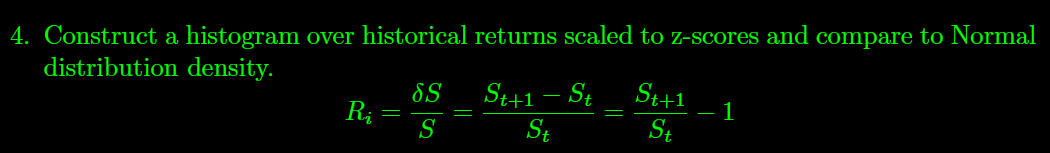

In [14]:
returns = data.pipe(compute_returns).pipe(z_stand)["Return"]

In [15]:
def norm_fig(data: pd.Series):
    x = np.linspace(data.min(), data.max(), 100)
    y = stats.norm.pdf(np.sort(np.array(x)))
    return px.line(
        x=x,
        y=y,
        color_discrete_sequence=["green"],
    )

In [16]:
def as_histogram(data: pd.Series, bins):
    
    # counts, bins = np.histogram(df.total_bill, bins=range(0, 60, 5))
    # bins = 0.5 * (bins[:-1] + bins[1:])
    # fig = px.bar(x=bins, y=counts, labels={'x':'total_bill', 'y':'count'})
    
    return px.histogram(
        data,
        nbins=bins,
        histnorm="probability density",
        opacity=0.4,
    )

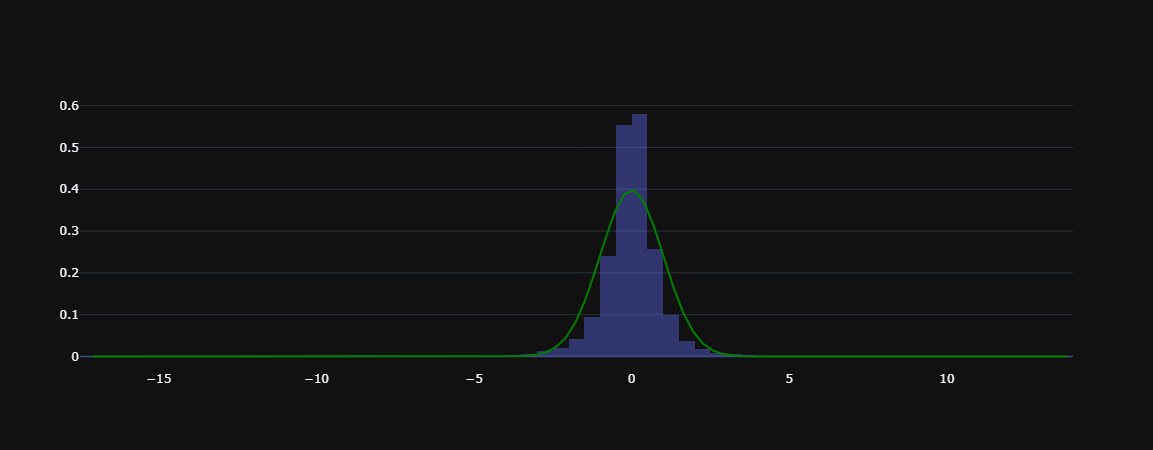

In [17]:
def hist_fig(data: pd.Series, bins=None):
    return go.Figure(
        data=data.pipe(as_histogram, bins=bins).data + data.pipe(norm_fig).data,
    ).update_layout(autosize=False, showlegend=False)

hist_fig(returns, bins=100)

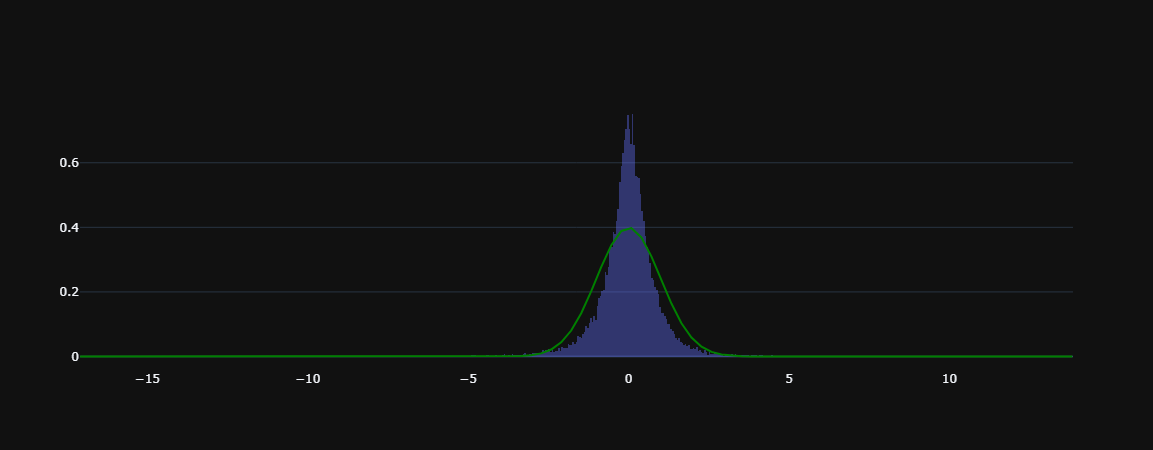

In [18]:
hist_fig(returns, bins=1000)

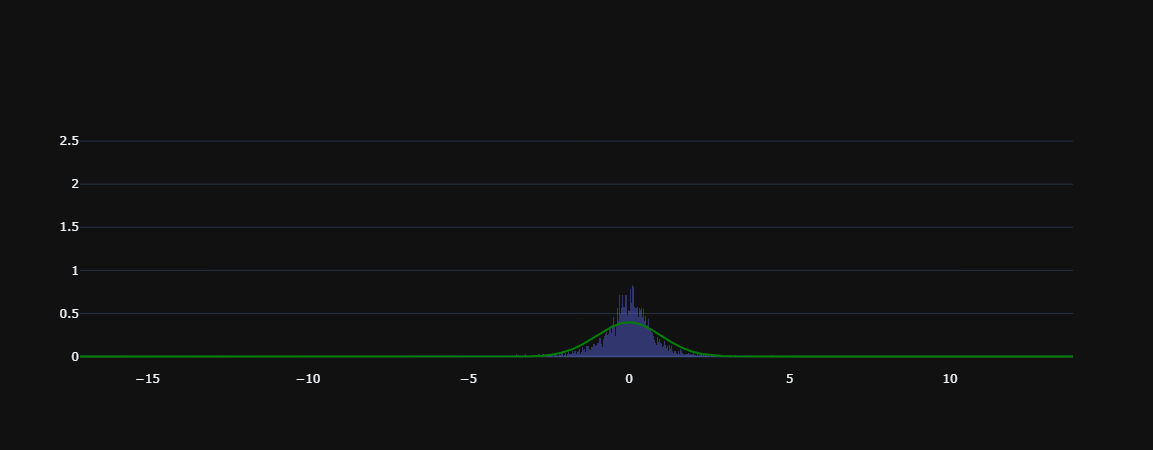

In [19]:
hist_fig(returns, bins=10000)